In [726]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


In [877]:
train = pd.read_csv('cosmo_titanic_train.csv')
test = pd.read_csv('titanic_test.csv')

In [878]:
df = pd.concat([train, test]).reset_index()
df.head()

,index,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Достанем информацию из столбцов без пропусков

In [879]:
df.loc[:,['GroupId']] = df.PassengerId.str.split("_",expand=True).iloc[:,0]
df.loc[:,['MemberId']] = df.PassengerId.str.split("_",expand=True).iloc[:,1]

Добавим колонку с размером группы

In [880]:
df['Group_size']=df['GroupId'].map(lambda x: df['GroupId'].value_counts()[x])

Найдем тех, кто путешествует один

In [881]:
df['Solo']=(df['Group_size']==1).astype(int)

Достанем информацию из "Cabin"

In [882]:
df[['Deck', 'Cab_num', 'Deck_side']] = df.Cabin.str.split('/', expand=True)
df.Cab_num = df.Cab_num.astype(float)

Достанем фамилию

In [883]:
df['Name'].fillna('Unknown Unknown', inplace=True)
df['Surname'] = df['Name'].str.split(expand=True)[1]

In [884]:
df.VIP.value_counts(dropna=False)

False    12401
NaN        296
True       273
Name: VIP, dtype: int64

В столбце VIP очнь маленькая доля значений True, поэтому заменим пропуски значением False

In [885]:
df.loc[df['VIP'].isna(),'VIP']=False

Для тех, кто путешествует группой одинаковые значения Deck_side и HomePlanet внутри группы

In [886]:
GCS_gb=df[df['Group_size']>1].groupby(['GroupId','Deck_side'])['Deck_side'].size().unstack().fillna(0)
GCS_index=df[df['Deck_side'].isna()][(df[df['Deck_side'].isna()]['GroupId']).isin(GCS_gb.index)].index
df.loc[GCS_index,'Deck_side']=df.iloc[GCS_index,:]['GroupId'].map(lambda x: GCS_gb.idxmax(axis=1)[x])

In [887]:
GSHP_gb=df[df['Group_size']>1].groupby(['GroupId','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GSHP_index=df[df['HomePlanet'].isna()][(df[df['HomePlanet'].isna()]['GroupId']).isin(GSHP_gb.index)].index
df.loc[GSHP_index,'HomePlanet']=df.iloc[GSHP_index,:]['GroupId'].map(lambda x: GSHP_gb.idxmax(axis=1)[x])

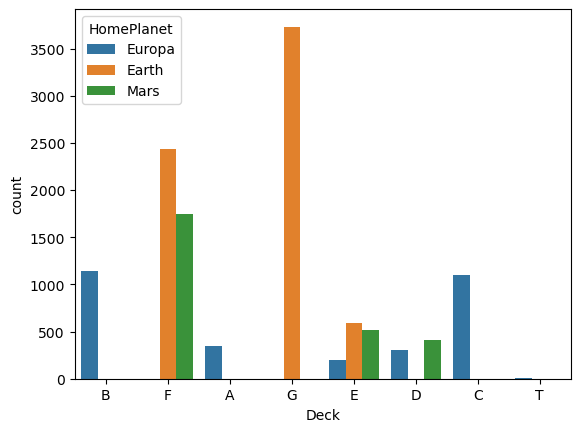

In [888]:
sns.countplot(data=df, x='Deck',
             hue='HomePlanet')
plt.show()

Нашли связь между Deck и Homeplanet

In [889]:
df.loc[df["Deck"].isin(['A', 'B', 'C', 'T']), 'HomePlanet'] = df.loc[df["Deck"].isin(['A', 'B', 'C', 'T']), 'HomePlanet'].fillna('Europa')
df.loc[df["Deck"].isin(['G']), 'HomePlanet'] = df.loc[df["Deck"].isin(['G']), 'HomePlanet'].fillna('Earth')
df.loc[(df['Destination'] == 'PSO J318.5-22') & (df.HomePlanet.isna()), 'HomePlanet'] = 'Earth'

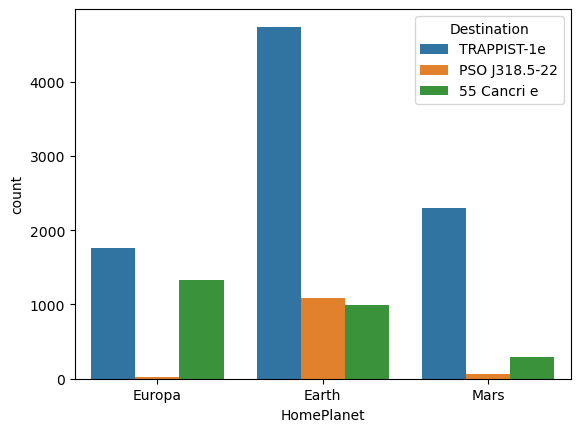

In [890]:
sns.countplot(data=df, x='HomePlanet',
             hue='Destination')
plt.show()

In [891]:
df[(df['Deck']=='D')]['HomePlanet'].value_counts(dropna=False)

Mars      410
Europa    301
NaN         9
Name: HomePlanet, dtype: int64

In [892]:
df[(df['Deck']!='D')]['HomePlanet'].value_counts(dropna=False)

Earth     6970
Europa    2887
Mars      2314
NaN         79
Name: HomePlanet, dtype: int64

Оставшиеся пропуски в столбце HomePlanet, заменим самым частым значеним с группировкой по Deck

In [893]:
df.loc[(df['HomePlanet'].isna()) & (df['Deck']!='D'), 'HomePlanet']='Earth'
df.loc[(df['HomePlanet'].isna()) & (df['Deck']=='D'), 'HomePlanet']='Mars'

Логично предполоожить ,что если человек в "криосне", то никаких трат он совершить не сможет.
Поэтому для этих пассажиров пропуски в столбцах с тратами можно заменить на 0.

In [894]:
services = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df.loc[df.CryoSleep == True, services] = df.loc[df.CryoSleep == True, services].fillna(0)

Пропуски в столбцах с тратами заполним средним значением с группировкой по другим категориальным столбцам

In [895]:
for i in services: 
    df[i] = df[i].fillna(df.groupby(['HomePlanet','Solo'])[i].transform('mean'))

Добавим столбец с общими тратами на все услуги

In [896]:
df['total_costs'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']

Категориальный столбец с меткой о том что у пассажира нету никаких трат

In [898]:
df['No_costs'] = (df['total_costs']==0).astype(int)

Те, у кого общие траты равны 0 скорее всего в "криосне"

In [899]:
df.loc[(df['total_costs'] == 0)& (df['CryoSleep'].isna()), 'CryoSleep'] = True

Соответственно те, у кого есть какие либо траты, точно не в "криосне"

In [901]:
df.loc[df['total_costs'] > 0, 'CryoSleep'] = df.loc[df['total_costs'] > 0, 'CryoSleep'].fillna(False)


In [900]:
df['Destination'].value_counts(dropna=False)

TRAPPIST-1e      8871
55 Cancri e      2641
PSO J318.5-22    1184
NaN               274
Name: Destination, dtype: int64

In [902]:
df.loc[(df['Destination'].isna()), 'Destination']='TRAPPIST-1e'

Добавим столбец с однофамильцами

In [904]:
df['Family_size']=df['Surname'].map(lambda x: df['Surname'].value_counts()[x])


In [905]:
df.loc[df['Surname']=='Unknown','Surname']=np.nan
df.loc[df['Family_size']>100,'Family_size']=0

Пассажиры с одной фамилией могут быть в разных кабинах,но у них всегда одна и та же "Deck_side"

In [906]:
SCS_gb=df[df['Group_size']>1].groupby(['Surname','Deck_side'])['Deck_side'].size().unstack().fillna(0)
SCS_gb['Ratio']=SCS_gb['P']/(SCS_gb['P']+SCS_gb['S'])
SCS_gb.drop('Ratio', axis=1, inplace=True)
SCS_index=df[df['Deck_side'].isna()][(df[df['Deck_side'].isna()]['Surname']).isin(SCS_gb.index)].index
df.loc[SCS_index,'Deck_side']=df.iloc[SCS_index,:]['Surname'].map(lambda x: SCS_gb.idxmax(axis=1)[x])

In [907]:
df.loc[df['Deck_side'].isna(),'Deck_side']='Z'

Возраст заполним медианным значением с группировкой по категориальным столбцам

In [908]:
df['Age'] = df['Age'].fillna(df.groupby(['HomePlanet','No_costs','Solo','Deck'])['Age'].transform('median'))

In [910]:
df['Age'] = df['Age'].fillna(df['Age'].median())

In [922]:
GCD_gb=df[df['Group_size']>1].groupby(['GroupId','Deck'])['Deck'].size().unstack().fillna(0)
GCD_index=df[df['Deck'].isna()][(df[df['Deck'].isna()]['GroupId']).isin(GCD_gb.index)].index
df.loc[GCD_index,'Deck']=df.iloc[GCD_index,:]['GroupId'].map(lambda x: GCD_gb.idxmax(axis=1)[x])

In [923]:
CD_bef=df['Deck'].isna().sum()
na_rows_CD=df.loc[df['Deck'].isna(),'Deck'].index
df.loc[df['Deck'].isna(),'Deck']=df.groupby(['HomePlanet','Destination','Solo'])['Deck'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CD]

In [925]:
from sklearn.linear_model import LinearRegression, LogisticRegression

preds_CN_all = []
for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    X_CN=df.loc[(df['Cab_num'].notna()) & (df['Deck']==deck),'GroupId']
    y_CN=df.loc[(df['Cab_num'].notna()) & (df['Deck']==deck),'Cab_num']
    X_test_CN=df.loc[(df['Cab_num'].isna()) & (df['Deck']==deck),'GroupId']

    model_CN=LinearRegression()
    model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
    preds_CN=model_CN.predict(X_test_CN.values.reshape(-1, 1))

    df.loc[(df['Cab_num'].isna()) & (df['Deck']==deck),'Cab_num']=preds_CN.astype(int)

Зазделим на группы по номерам кабины

In [926]:
cabin_group = pd.cut(x=df.Cab_num.astype('float'),
                  bins=[-10, 300, 600, 900, 1200, 1500, 1800, 1.e+10],
                  labels=['Cab_r_1', 'Cab_r_2', 'Cab_r_3', 'Cab_r_4', 'Cab_r_5', 'Cab_r_6', 'Cab_r_7'])
if 'Cabin_Region' in df.columns:
    df = df.drop('Cabin_Region', axis=1)
    df.insert(df.shape[1],'Cabin_Region', cabin_group)
else:
    df.insert(df.shape[1],'Cabin_Region', cabin_group)
    

возраст так же разделим на группы

In [927]:
age_group = pd.cut(x=df.Age.astype(float),
                  bins=[-1, 12, 18, 25, 30, 50, 1.e+10],
                  labels=['Age_0-12', 'Age_13-17', 'Age_18-25', 'Age_26-30', 'Age_31-50', 'Age_51+'])
if 'Age_Group' in df.columns:
    df = df.drop('Age_Group', axis=1)
    df.insert(df.shape[1],'Age_Group', age_group)
else:
    df.insert(df.shape[1],'Age_Group', age_group)

In [924]:
(df.isna().mean() * 100).round(2)

index            0.00
PassengerId      0.00
HomePlanet       0.00
CryoSleep        0.00
Cabin            2.31
Destination      0.00
Age              0.00
VIP              0.00
RoomService      0.00
FoodCourt        0.00
ShoppingMall     0.00
Spa              0.00
VRDeck           0.00
Name             0.00
Transported     32.98
GroupId          0.00
MemberId         0.00
Group_size       0.00
Solo             0.00
Deck             0.00
Cab_num          2.31
Deck_side        0.00
Surname          2.27
total_costs      0.00
No_costs         0.00
Family_size      0.00
dtype: float64

In [928]:
df.head()

,index,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,...,Solo,Deck,Cab_num,Deck_side,Surname,total_costs,No_costs,Family_size,Cabin_Region,Age_Group
0,0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,...,1,B,0.0,P,Ofracculy,0.0,1,3,Cab_r_1,Age_31-50
1,1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,...,1,F,0.0,S,Vines,736.0,0,4,Cab_r_1,Age_18-25
2,2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,...,0,A,0.0,S,Susent,10383.0,0,7,Cab_r_1,Age_51+
3,3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,...,0,A,0.0,S,Susent,5176.0,0,7,Cab_r_1,Age_31-50
4,4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,...,1,F,1.0,S,Santantines,1091.0,0,9,Cab_r_1,Age_13-17


In [852]:
df.columns

Index(['index', 'PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin',
       'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Name', 'Transported', 'GroupId', 'MemberId',
       'Group_size', 'Solo', 'Deck', 'Cab_num', 'Deck_side', 'Surname',
       'total_costs', 'No_costs', 'Cabin_Region', 'Age_Group'],
      dtype='object')

In [929]:
df = df.drop(columns=['index', 'PassengerId', 'Cabin', 'Name', 'GroupId', 'MemberId', 'Cab_num', 'Surname'])

In [930]:
#le = LabelEncoder()
#df_.Transported = le.fit_transform(df.Transported)
df = pd.get_dummies(df, columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP','Group_size', 'Solo', 'Deck', 'Deck_side', 'No_costs', 'Family_size', 'Cabin_Region', 'Age_Group'])
scaler = MinMaxScaler()
names = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'total_costs']
d = scaler.fit_transform(df_[names])
scaled_df = pd.DataFrame(d, columns=names)
scaled_df.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total_costs
0,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.303797,0.010935,0.000435,0.001534,0.034920,0.002628,0.029208
2,0.734177,0.004324,0.163431,0.000000,0.378145,0.002926,0.365716
3,0.417722,0.000000,0.060787,0.022606,0.199830,0.011492,0.193872
4,0.202532,0.030193,0.003383,0.009244,0.035925,0.000120,0.043088


In [931]:
df = df.drop(columns=names, axis=1).reset_index()
df = df.join(scaled_df)
df.head()

,index,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,...,Age_Group_Age_26-30,Age_Group_Age_31-50,Age_Group_Age_51+,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total_costs
0,0,False,0,1,0,1,0,0,0,1,...,0,1,0,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,True,1,0,0,1,0,0,0,1,...,0,0,0,0.303797,0.010935,0.000435,0.001534,0.034920,0.002628,0.029208
2,2,False,0,1,0,1,0,0,0,1,...,0,0,1,0.734177,0.004324,0.163431,0.000000,0.378145,0.002926,0.365716
3,3,False,0,1,0,1,0,0,0,1,...,0,1,0,0.417722,0.000000,0.060787,0.022606,0.199830,0.011492,0.193872
4,4,True,1,0,0,1,0,0,0,1,...,0,0,0,0.202532,0.030193,0.003383,0.009244,0.035925,0.000120,0.043088


Прологарифмируем численные столбцы, чтобы распределение было больше похоже на нормальное

In [933]:
for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','total_costs']:
    df[col]=np.log(1+df[col])

In [934]:
train = df[df['Transported'].notna()]
test = df[df['Transported'].isna()]

In [935]:
le = LabelEncoder()
train.Transported = le.fit_transform(train.Transported)

C:\Users\orlov\AppData\Local\Temp\ipykernel_19364\1609863407.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.Transported = le.fit_transform(train.Transported)


In [936]:
X = train.drop(columns=['index', 'Transported'], axis=1)
y = train.Transported

Попробуем разные модели для выбора с чем потом работать

In [940]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose = 0,
                     ignore_warnings = True,
                     custom_metric = None,
                     predictions = False,
                     classifiers = 'all')

models, predictions = clf.fit(X_train, X_test ,y_train , y_test)

100%|██████████| 29/29 [00:44<00:00,  1.53s/it]


In [939]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.80,0.80,0.80,0.80,0.30
XGBClassifier,0.79,0.79,0.79,0.79,1.16
AdaBoostClassifier,0.79,0.79,0.79,0.79,0.87
RandomForestClassifier,0.78,0.78,0.78,0.78,1.37
LogisticRegression,0.78,0.78,0.78,0.78,0.19
CalibratedClassifierCV,0.78,0.78,0.78,0.78,6.37
LinearSVC,0.78,0.78,0.78,0.78,1.95
SVC,0.78,0.78,0.78,0.78,4.28
NuSVC,0.78,0.78,0.78,0.78,5.95


Попробуем еще один классификатор

In [1083]:
from catboost import CatBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

clf = CatBoostClassifier(
    learning_rate= 0.015, #0.015
    use_best_model= True,
    depth= 4,  #4
    iterations=1000, #1000
    #verbose=5,
)
clf.fit(
    X_train, y_train,
    cat_features=[0, 1],
    eval_set=(X_test, y_test),
)

0:	learn: 0.6866257	test: 0.6867297	best: 0.6867297 (0)	total: 5.24ms	remaining: 5.24s
1:	learn: 0.6798403	test: 0.6799922	best: 0.6799922 (1)	total: 10.7ms	remaining: 5.32s
2:	learn: 0.6737397	test: 0.6739080	best: 0.6739080 (2)	total: 15.5ms	remaining: 5.15s
3:	learn: 0.6677312	test: 0.6680207	best: 0.6680207 (3)	total: 20.9ms	remaining: 5.21s
4:	learn: 0.6623293	test: 0.6626580	best: 0.6626580 (4)	total: 26.2ms	remaining: 5.21s
5:	learn: 0.6563076	test: 0.6565176	best: 0.6565176 (5)	total: 31.6ms	remaining: 5.24s
6:	learn: 0.6499261	test: 0.6501403	best: 0.6501403 (6)	total: 37.1ms	remaining: 5.27s
7:	learn: 0.6454926	test: 0.6457207	best: 0.6457207 (7)	total: 42.8ms	remaining: 5.31s
8:	learn: 0.6412622	test: 0.6416749	best: 0.6416749 (8)	total: 48.4ms	remaining: 5.33s
9:	learn: 0.6360451	test: 0.6364344	best: 0.6364344 (9)	total: 54.5ms	remaining: 5.4s
10:	learn: 0.6311076	test: 0.6317107	best: 0.6317107 (10)	total: 61.5ms	remaining: 5.53s
11:	learn: 0.6265774	test: 0.6272880	best:

97:	learn: 0.4777318	test: 0.4873670	best: 0.4873670 (97)	total: 596ms	remaining: 5.49s
98:	learn: 0.4770739	test: 0.4868198	best: 0.4868198 (98)	total: 603ms	remaining: 5.49s
99:	learn: 0.4761806	test: 0.4860766	best: 0.4860766 (99)	total: 610ms	remaining: 5.49s
100:	learn: 0.4754486	test: 0.4854258	best: 0.4854258 (100)	total: 618ms	remaining: 5.5s
101:	learn: 0.4747799	test: 0.4848911	best: 0.4848911 (101)	total: 626ms	remaining: 5.51s
102:	learn: 0.4741847	test: 0.4844563	best: 0.4844563 (102)	total: 633ms	remaining: 5.51s
103:	learn: 0.4733529	test: 0.4837343	best: 0.4837343 (103)	total: 640ms	remaining: 5.52s
104:	learn: 0.4727629	test: 0.4831757	best: 0.4831757 (104)	total: 646ms	remaining: 5.51s
105:	learn: 0.4721805	test: 0.4826049	best: 0.4826049 (105)	total: 652ms	remaining: 5.5s
106:	learn: 0.4715214	test: 0.4819177	best: 0.4819177 (106)	total: 659ms	remaining: 5.5s
107:	learn: 0.4710014	test: 0.4814389	best: 0.4814389 (107)	total: 664ms	remaining: 5.49s
108:	learn: 0.47034

207:	learn: 0.4323167	test: 0.4485905	best: 0.4485905 (207)	total: 1.4s	remaining: 5.31s
208:	learn: 0.4321182	test: 0.4484415	best: 0.4484415 (208)	total: 1.4s	remaining: 5.31s
209:	learn: 0.4319127	test: 0.4483048	best: 0.4483048 (209)	total: 1.41s	remaining: 5.31s
210:	learn: 0.4316452	test: 0.4480782	best: 0.4480782 (210)	total: 1.42s	remaining: 5.32s
211:	learn: 0.4309953	test: 0.4475107	best: 0.4475107 (211)	total: 1.43s	remaining: 5.33s
212:	learn: 0.4307322	test: 0.4472665	best: 0.4472665 (212)	total: 1.45s	remaining: 5.35s
213:	learn: 0.4305516	test: 0.4471224	best: 0.4471224 (213)	total: 1.46s	remaining: 5.34s
214:	learn: 0.4302214	test: 0.4467953	best: 0.4467953 (214)	total: 1.46s	remaining: 5.34s
215:	learn: 0.4299060	test: 0.4465076	best: 0.4465076 (215)	total: 1.47s	remaining: 5.34s
216:	learn: 0.4296878	test: 0.4463945	best: 0.4463945 (216)	total: 1.48s	remaining: 5.33s
217:	learn: 0.4294655	test: 0.4461987	best: 0.4461987 (217)	total: 1.49s	remaining: 5.33s
218:	learn: 

311:	learn: 0.4114079	test: 0.4317018	best: 0.4317018 (311)	total: 2.4s	remaining: 5.29s
312:	learn: 0.4112858	test: 0.4316061	best: 0.4316061 (312)	total: 2.41s	remaining: 5.28s
313:	learn: 0.4110151	test: 0.4314258	best: 0.4314258 (313)	total: 2.42s	remaining: 5.29s
314:	learn: 0.4109248	test: 0.4313691	best: 0.4313691 (314)	total: 2.43s	remaining: 5.28s
315:	learn: 0.4107387	test: 0.4311811	best: 0.4311811 (315)	total: 2.44s	remaining: 5.28s
316:	learn: 0.4105152	test: 0.4309872	best: 0.4309872 (316)	total: 2.45s	remaining: 5.28s
317:	learn: 0.4100715	test: 0.4305549	best: 0.4305549 (317)	total: 2.46s	remaining: 5.27s
318:	learn: 0.4098918	test: 0.4304251	best: 0.4304251 (318)	total: 2.46s	remaining: 5.26s
319:	learn: 0.4097413	test: 0.4303056	best: 0.4303056 (319)	total: 2.47s	remaining: 5.25s
320:	learn: 0.4096296	test: 0.4301875	best: 0.4301875 (320)	total: 2.48s	remaining: 5.24s
321:	learn: 0.4095356	test: 0.4301395	best: 0.4301395 (321)	total: 2.49s	remaining: 5.24s
322:	learn:

409:	learn: 0.3969100	test: 0.4206149	best: 0.4206149 (409)	total: 3.6s	remaining: 5.18s
410:	learn: 0.3968455	test: 0.4205453	best: 0.4205453 (410)	total: 3.61s	remaining: 5.17s
411:	learn: 0.3965979	test: 0.4203058	best: 0.4203058 (411)	total: 3.62s	remaining: 5.17s
412:	learn: 0.3964809	test: 0.4202119	best: 0.4202119 (412)	total: 3.64s	remaining: 5.17s
413:	learn: 0.3963135	test: 0.4200783	best: 0.4200783 (413)	total: 3.66s	remaining: 5.18s
414:	learn: 0.3961789	test: 0.4199793	best: 0.4199793 (414)	total: 3.67s	remaining: 5.17s
415:	learn: 0.3959869	test: 0.4198327	best: 0.4198327 (415)	total: 3.68s	remaining: 5.17s
416:	learn: 0.3959092	test: 0.4197783	best: 0.4197783 (416)	total: 3.69s	remaining: 5.17s
417:	learn: 0.3957976	test: 0.4197576	best: 0.4197576 (417)	total: 3.7s	remaining: 5.15s
418:	learn: 0.3956978	test: 0.4196440	best: 0.4196440 (418)	total: 3.71s	remaining: 5.14s
419:	learn: 0.3954088	test: 0.4194380	best: 0.4194380 (419)	total: 3.72s	remaining: 5.13s
420:	learn: 

509:	learn: 0.3872189	test: 0.4142436	best: 0.4142436 (509)	total: 4.41s	remaining: 4.24s
510:	learn: 0.3871363	test: 0.4142257	best: 0.4142257 (510)	total: 4.43s	remaining: 4.24s
511:	learn: 0.3869367	test: 0.4140249	best: 0.4140249 (511)	total: 4.44s	remaining: 4.23s
512:	learn: 0.3868329	test: 0.4139854	best: 0.4139854 (512)	total: 4.46s	remaining: 4.23s
513:	learn: 0.3867126	test: 0.4139357	best: 0.4139357 (513)	total: 4.46s	remaining: 4.22s
514:	learn: 0.3866312	test: 0.4139002	best: 0.4139002 (514)	total: 4.48s	remaining: 4.22s
515:	learn: 0.3865263	test: 0.4138352	best: 0.4138352 (515)	total: 4.49s	remaining: 4.21s
516:	learn: 0.3864720	test: 0.4138204	best: 0.4138204 (516)	total: 4.5s	remaining: 4.21s
517:	learn: 0.3863802	test: 0.4137575	best: 0.4137575 (517)	total: 4.51s	remaining: 4.2s
518:	learn: 0.3862298	test: 0.4136368	best: 0.4136368 (518)	total: 4.52s	remaining: 4.19s
519:	learn: 0.3861109	test: 0.4136217	best: 0.4136217 (519)	total: 4.54s	remaining: 4.19s
520:	learn: 

608:	learn: 0.3786134	test: 0.4093069	best: 0.4093069 (608)	total: 5.65s	remaining: 3.63s
609:	learn: 0.3785252	test: 0.4092422	best: 0.4092422 (609)	total: 5.67s	remaining: 3.62s
610:	learn: 0.3784695	test: 0.4092080	best: 0.4092080 (610)	total: 5.67s	remaining: 3.61s
611:	learn: 0.3783051	test: 0.4091242	best: 0.4091242 (611)	total: 5.68s	remaining: 3.6s
612:	learn: 0.3782355	test: 0.4091054	best: 0.4091054 (612)	total: 5.7s	remaining: 3.6s
613:	learn: 0.3781607	test: 0.4090912	best: 0.4090912 (613)	total: 5.71s	remaining: 3.59s
614:	learn: 0.3781047	test: 0.4090882	best: 0.4090882 (614)	total: 5.73s	remaining: 3.58s
615:	learn: 0.3780403	test: 0.4090925	best: 0.4090882 (614)	total: 5.74s	remaining: 3.58s
616:	learn: 0.3779538	test: 0.4090281	best: 0.4090281 (616)	total: 5.76s	remaining: 3.57s
617:	learn: 0.3778850	test: 0.4090345	best: 0.4090281 (616)	total: 5.77s	remaining: 3.56s
618:	learn: 0.3778374	test: 0.4089931	best: 0.4089931 (618)	total: 5.78s	remaining: 3.56s
619:	learn: 0

706:	learn: 0.3705816	test: 0.4053127	best: 0.4053116 (705)	total: 6.47s	remaining: 2.68s
707:	learn: 0.3705231	test: 0.4052652	best: 0.4052652 (707)	total: 6.48s	remaining: 2.67s
708:	learn: 0.3704491	test: 0.4052374	best: 0.4052374 (708)	total: 6.48s	remaining: 2.66s
709:	learn: 0.3703960	test: 0.4052298	best: 0.4052298 (709)	total: 6.49s	remaining: 2.65s
710:	learn: 0.3703076	test: 0.4051757	best: 0.4051757 (710)	total: 6.52s	remaining: 2.65s
711:	learn: 0.3702541	test: 0.4051888	best: 0.4051757 (710)	total: 6.54s	remaining: 2.64s
712:	learn: 0.3702126	test: 0.4052065	best: 0.4051757 (710)	total: 6.55s	remaining: 2.64s
713:	learn: 0.3701164	test: 0.4051567	best: 0.4051567 (713)	total: 6.59s	remaining: 2.64s
714:	learn: 0.3700428	test: 0.4051289	best: 0.4051289 (714)	total: 6.6s	remaining: 2.63s
715:	learn: 0.3699718	test: 0.4051275	best: 0.4051275 (715)	total: 6.62s	remaining: 2.63s
716:	learn: 0.3698815	test: 0.4050903	best: 0.4050903 (716)	total: 6.63s	remaining: 2.62s
717:	learn:

815:	learn: 0.3620515	test: 0.4019935	best: 0.4019935 (815)	total: 7.48s	remaining: 1.69s
816:	learn: 0.3619878	test: 0.4020242	best: 0.4019935 (815)	total: 7.49s	remaining: 1.68s
817:	learn: 0.3619241	test: 0.4020272	best: 0.4019935 (815)	total: 7.5s	remaining: 1.67s
818:	learn: 0.3618477	test: 0.4019713	best: 0.4019713 (818)	total: 7.5s	remaining: 1.66s
819:	learn: 0.3617648	test: 0.4019232	best: 0.4019232 (819)	total: 7.51s	remaining: 1.65s
820:	learn: 0.3616934	test: 0.4018805	best: 0.4018805 (820)	total: 7.52s	remaining: 1.64s
821:	learn: 0.3616231	test: 0.4018349	best: 0.4018349 (821)	total: 7.53s	remaining: 1.63s
822:	learn: 0.3615792	test: 0.4018594	best: 0.4018349 (821)	total: 7.54s	remaining: 1.62s
823:	learn: 0.3615250	test: 0.4017961	best: 0.4017961 (823)	total: 7.55s	remaining: 1.61s
824:	learn: 0.3614571	test: 0.4017407	best: 0.4017407 (824)	total: 7.55s	remaining: 1.6s
825:	learn: 0.3613613	test: 0.4017161	best: 0.4017161 (825)	total: 7.56s	remaining: 1.59s
826:	learn: 0

931:	learn: 0.3542492	test: 0.3996970	best: 0.3996668 (929)	total: 8.48s	remaining: 619ms
932:	learn: 0.3541879	test: 0.3997026	best: 0.3996668 (929)	total: 8.49s	remaining: 610ms
933:	learn: 0.3540896	test: 0.3996666	best: 0.3996666 (933)	total: 8.5s	remaining: 600ms
934:	learn: 0.3540302	test: 0.3996733	best: 0.3996666 (933)	total: 8.5s	remaining: 591ms
935:	learn: 0.3539930	test: 0.3996508	best: 0.3996508 (935)	total: 8.51s	remaining: 582ms
936:	learn: 0.3539614	test: 0.3996455	best: 0.3996455 (936)	total: 8.52s	remaining: 573ms
937:	learn: 0.3539120	test: 0.3996371	best: 0.3996371 (937)	total: 8.53s	remaining: 564ms
938:	learn: 0.3538629	test: 0.3995997	best: 0.3995997 (938)	total: 8.53s	remaining: 554ms
939:	learn: 0.3538064	test: 0.3995945	best: 0.3995945 (939)	total: 8.54s	remaining: 545ms
940:	learn: 0.3537454	test: 0.3995351	best: 0.3995351 (940)	total: 8.55s	remaining: 536ms
941:	learn: 0.3536839	test: 0.3994717	best: 0.3994717 (941)	total: 8.56s	remaining: 527ms
942:	learn: 

In [1084]:
print('Accuracy on train set: {:.3f}'.format(clf.score(X_train, y_train)))
print('Accuracy test set: {:.3f}'.format(clf.score(X_test, y_test)))

Accuracy on train set: 0.842
Accuracy test set: 0.800


In [961]:
test = test.drop(columns=['index', 'Transported'])

In [1085]:
predicted = clf.predict(test)

Функция записывает предсказания в файл csv для отправки на Kaggle

In [1042]:
def get_submission(predicted):
    f = pd.read_csv('sample_submission_1.csv')
    f['Transported'] = le.inverse_transform(predicted)
    return f.to_csv('submission.csv', index=False)

In [1086]:
get_submission(predicted)

score=0.81108 (top90/2367) 

# Попробуем подобрать treshold для лучшей точности

Функция возвращает метрику accuracy и массив с предсказаниями

In [1062]:
def find_acc(model = clf, tresh=0.5, y_val=y_test):
    pred_prob = clf.predict_proba(X_test)
    predicted = []
    for i in pred_prob:

        if i[1] > tresh:
            predicted.append(1)
        else:
            predicted.append(0)

    predicted = np.asarray(predicted)
    return accuracy_score(y_val, predicted), predicted

Функция находит лучший treshold и accuracy для выбранной модели

In [1072]:
def find_best_treshold(model = clf, y_val = y_test):
    best_tresh = 0
    best_acc = find_acc(model, 0, y_val)[0]
    
    for i in np.arange(0,1,0.001):
        if find_acc(model, i, y_val)[0] > best_acc:
            best_acc = find_acc(model, i, y_val)[0]
            best_tresh = i
    print(best_tresh, best_acc)
    return best_tresh, best_acc
    

In [1076]:
find_best_treshold(clf, y_test)

0.48 0.8052147239263804


(0.48, 0.8052147239263804)

In [1081]:
predicted = []
for i in clf.predict_proba(test):
    if i[1] > 0.48:
        predicted.append(1)
    else:
         predicted.append(0)
predicted = np.asarray(predicted)

In [1082]:
get_submission(predicted)

score=0.8043 Точность понизилась(
Оставляем как было